# Britannia Stock Price Prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Impor data
df_ori = pd.read_csv('BRITANNIA.csv')
df_ori

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,BRITANNIA,EQ,703.25,705.00,759.50,705.0,758.0,756.90,741.01,7512,5.566488e+11,NaN,NaN,NaN
1,2000-01-04,BRITANNIA,EQ,756.90,710.00,770.00,710.0,740.0,754.55,742.52,8135,6.040391e+11,NaN,NaN,NaN
2,2000-01-05,BRITANNIA,EQ,754.55,755.00,759.00,705.0,740.0,735.30,739.92,6095,4.509784e+11,NaN,NaN,NaN
3,2000-01-06,BRITANNIA,EQ,735.30,740.00,794.15,740.0,770.0,785.65,788.83,19697,1.553756e+12,NaN,NaN,NaN
4,2000-01-07,BRITANNIA,EQ,785.65,808.00,848.50,798.0,848.5,848.50,827.53,33107,2.739708e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5300,2021-04-26,BRITANNIA,EQ,3650.30,3661.10,3662.00,3531.0,3546.0,3539.20,3558.62,1031406,3.670382e+14,72258.0,507276.0,0.4918
5301,2021-04-27,BRITANNIA,EQ,3539.20,3572.70,3574.60,3517.0,3546.0,3541.20,3539.42,813608,2.879697e+14,46189.0,322686.0,0.3966
5302,2021-04-28,BRITANNIA,EQ,3541.20,3488.00,3527.00,3469.0,3470.0,3478.75,3495.13,1498181,5.236339e+14,97170.0,763715.0,0.5098
5303,2021-04-29,BRITANNIA,EQ,3478.75,3496.75,3505.90,3447.0,3464.0,3468.90,3471.18,611087,2.121195e+14,41655.0,309653.0,0.5067


In [3]:
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5305 entries, 0 to 5304
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                5305 non-null   object 
 1   Symbol              5305 non-null   object 
 2   Series              5305 non-null   object 
 3   Prev Close          5305 non-null   float64
 4   Open                5305 non-null   float64
 5   High                5305 non-null   float64
 6   Low                 5305 non-null   float64
 7   Last                5305 non-null   float64
 8   Close               5305 non-null   float64
 9   VWAP                5305 non-null   float64
 10  Volume              5305 non-null   int64  
 11  Turnover            5305 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  4796 non-null   float64
 14  %Deliverble         4796 non-null   float64
dtypes: float64(11), int64(1), object(3)
memory usage: 621.8

## Data Cleaning

In [4]:
# Kita akan spesifik menggunakan data Prev Close pada 2014
df = df_ori['Prev Close']
df.index = pd.to_datetime(df_ori.Date)
df = df['2014-01-01':'2014-12-31']
df

Date
2014-01-01     920.60
2014-01-02     918.45
2014-01-03     909.20
2014-01-06     916.85
2014-01-07     908.90
               ...   
2014-12-24    1764.10
2014-12-26    1755.40
2014-12-29    1731.15
2014-12-30    1780.20
2014-12-31    1784.00
Name: Prev Close, Length: 244, dtype: float64

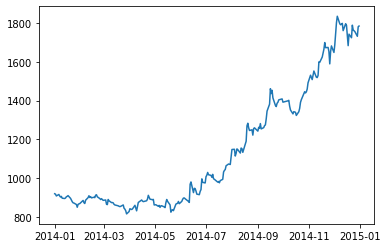

In [5]:
plt.plot(df)
plt.show()

In [6]:
if df.index.freq is None:
    freq = pd.infer_freq(df.index)
    df.index.freq = pd.tseries.frequencies.to_offset(freq)

'freq=None' if df.index.freq is None else df.index.freq

'freq=None'

In [7]:
df = df.asfreq(freq='D')
df.interpolate(inplace=True)
df

Date
2014-01-01     920.600000
2014-01-02     918.450000
2014-01-03     909.200000
2014-01-04     911.750000
2014-01-05     914.300000
                 ...     
2014-12-27    1747.316667
2014-12-28    1739.233333
2014-12-29    1731.150000
2014-12-30    1780.200000
2014-12-31    1784.000000
Freq: D, Name: Prev Close, Length: 365, dtype: float64

## Stationarity Check

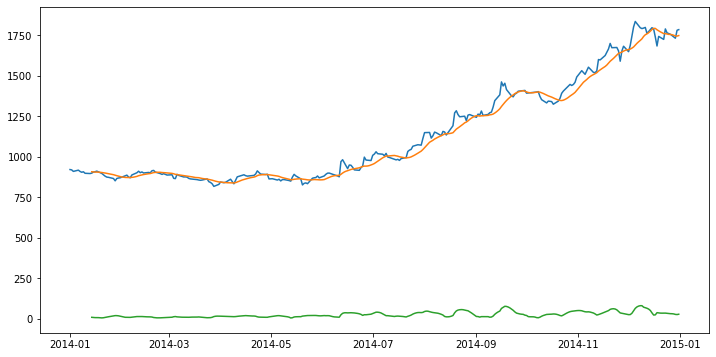

In [8]:
rollingmean = df.rolling(14).mean()
rollingstd = df.rolling(14).std()

plt.figure(figsize=(12, 6))
plt.plot(df, label='Original')
plt.plot(rollingmean, label='Mean')
plt.plot(rollingstd, label='std')
plt.show()

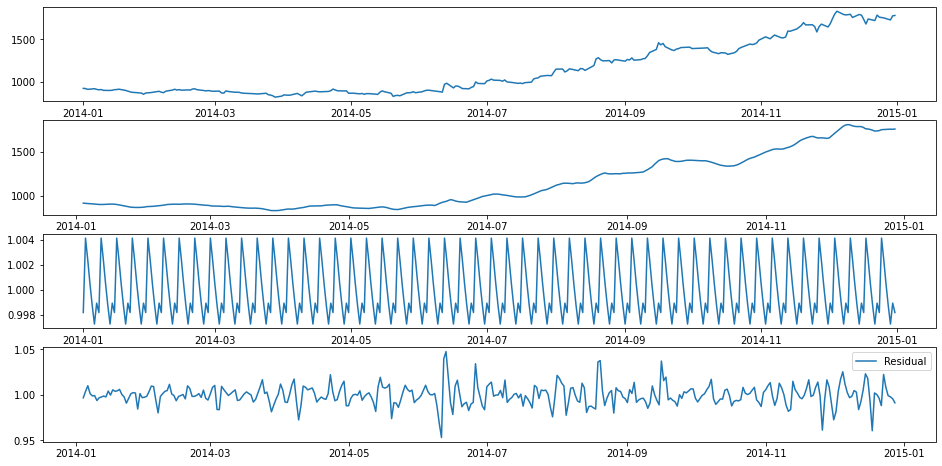

In [27]:
# Dekomposisi
from statsmodels.tsa.seasonal import seasonal_decompose

dekomposisi = seasonal_decompose(df, model='multiplicative')
trend = dekomposisi.trend
seasonal = dekomposisi.seasonal
residu = dekomposisi.resid

fig, ax = plt.subplots(4, 1, figsize=(16, 8))
ax[0].plot(df, label='Original')
ax[1].plot(trend, label='Trend')
ax[2].plot(seasonal, label='Seasonality')
ax[3].plot(residu, label='Residual')
plt.legend(loc='best')
plt.show()

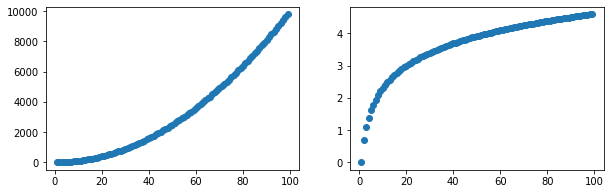

In [18]:
# Experiment
x = np.array([range(1, 100)])

fig = plt.figure(1, figsize=(10, 3))
plt.subplot(121)
plt.scatter(x, x**2)
plt.subplot(122)
plt.scatter(x, np.log(x))
plt.show()

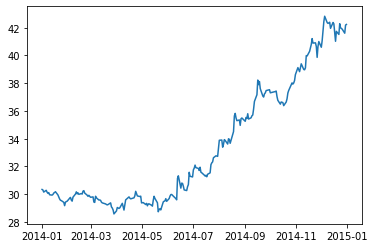

In [19]:
# Transformasi akar kuadrat
df_sqrt = np.sqrt(df)

plt.plot(df_sqrt)
plt.show()

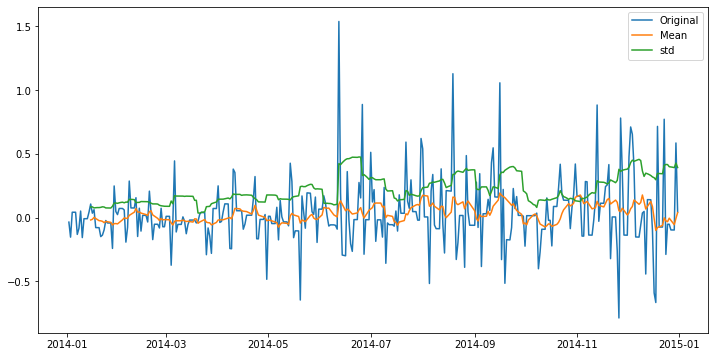

In [61]:
# Difference Transform
df_sqrt_diff = df_sqrt - df_sqrt.shift(1)

rollingmean = df_sqrt_diff.rolling(14).mean()
rollingstd = df_sqrt_diff.rolling(14).std()

plt.figure(figsize=(12, 6))
plt.plot(df_sqrt_diff, label='Original')
plt.plot(rollingmean, label='Mean')
plt.plot(rollingstd, label='std')
plt.legend()
plt.show()

In [70]:
# Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

hasil_adfuller = adfuller(df_sqrt_diff.dropna(), autolag='AIC')

print(f'ADF Statistik: {hasil_adfuller[0]}')
print(f'p-value: {hasil_adfuller[1]}')
print(hasil_adfuller[4])

ADF Statistik: -17.315528526455335
p-value: 5.521292515475427e-30
{'1%': -3.448493650810824, '5%': -2.8695352280356556, '10%': -2.5710293341377715}


## Modelling

In [72]:
# Mari kita cari nilai lag AR dan MA yang optimal untuk awal menggunakan acf dan pacf
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(df_sqrt_diff, nlags=30)
lag_pacf = pacf(df_sqrt_diff, nlags=30)

D:\equipments\miniconda\envs\iddzzz\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


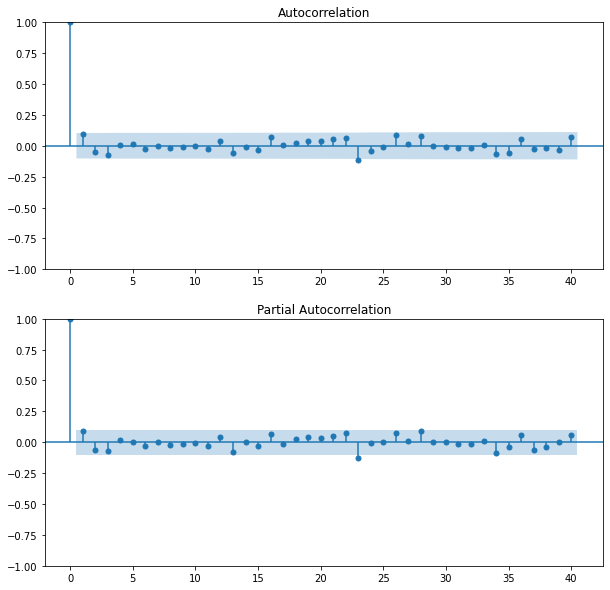

In [74]:
import statsmodels.api as sm

import statsmodels.api as sm
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
sm.graphics.tsa.plot_acf(df_sqrt_diff.dropna(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(df_sqrt_diff.dropna(), lags=40, ax=ax[1])
plt.show()

Mari kita pakai AR = 1, dan MA = 1.

In [77]:
# model ARIMA
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_sqrt_diff, order=(1, 1, 1))
hasil_arima = model.fit()

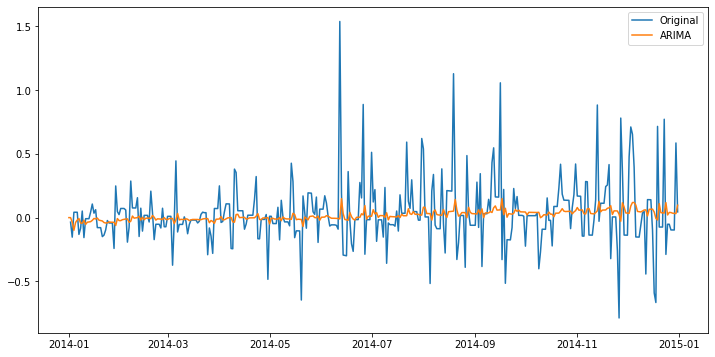

In [79]:
plt.figure(figsize=(12, 6))
plt.plot(df_sqrt_diff, label='Original')
plt.plot(hasil_arima.fittedvalues, label='ARIMA')
plt.legend()
plt.show()

RMSE: 262.5215848315879


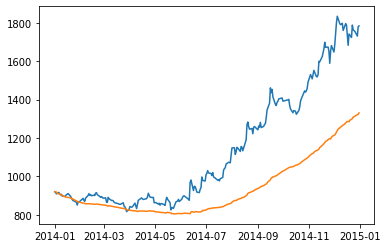

In [98]:
# Kembalikan ke skala original
# Tadi kita pakai sqrt -> diff

from sklearn.metrics import mean_squared_error

def kembalikan(hasil, ref_bf_diff=df_sqrt):
    arima_pred = pd.Series(hasil, copy=True)
    arima_pred = arima_pred.cumsum() # Ambil cummulative sum
    arima_pred = pd.Series(df_sqrt.iloc[0], index=ref_bf_diff.index).add(arima_pred, fill_value=0) # Tambahkan dengan data pertama
    return arima_pred**2

arima_pred = kembalikan(hasil_arima.fittedvalues, df_sqrt)

print(f'RMSE: {mean_squared_error(df, arima_pred, squared=False)}')

plt.plot(df, label='Original')
plt.plot(arima_pred, label='ARIMA')
plt.show()

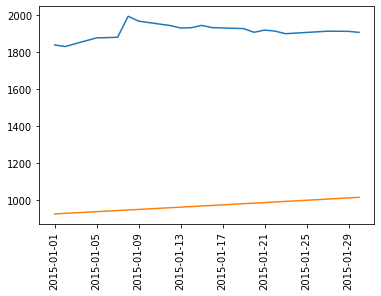

In [107]:
# Kita coba prediksi nilai pada Januari 2015
jan = df_ori['Prev Close']
jan.index = pd.to_datetime(df_ori.Date)
jan = jan['2015-01-01':'2015-01-31']
jan = jan.asfreq(freq='D')
jan.interpolate(inplace=True)
jan_sqrt = np.sqrt(jan)

plt.plot(jan)
plt.plot(kembalikan(hasil_arima.predict('2015-01-01', '2015-01-30'), jan_sqrt))
plt.xticks(rotation=90)
plt.show()

## Tuning